## Imports & Utils

In [1]:
from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
from math import log2
import umap

import bz2
import pickle
import _pickle as cPickle
import pathlib
from os.path import join

from torchvision.utils import make_grid

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from tqdm.notebook import trange
import cv2
from tqdm import tqdm
import glob
from easydict import EasyDict
from hierarchical_keypoints.stn import STNClsNet

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(1)

In [3]:
def make_dirs(path):
    pathlib.Path(path).mkdir(parents=True, exist_ok=True)


def compress_pickle(fname, data):
    with bz2.BZ2File(fname, "wb") as f:
        cPickle.dump(data, f)


def decompress_pickle(file):
    data = bz2.BZ2File(file, "rb")
    data = cPickle.load(data)
    return data


## Setup Dataloader

In [61]:
class ImageFolderv2(ImageFolder):
    """
    Attributes:
       classes (list): List of the class names sorted alphabetically.
       class_to_idx (dict): Dict with items (class_name, class_index).
       imgs (list): List of (image path, class_index) tuples
    """

    def __init__(self, root: str, transform=None, is_valid_file=None, internal_resize=(256, 256)):
        super().__init__(
            root,
            transform=transform,
            is_valid_file=is_valid_file,
        )

        self.data = []
        self.targets = []

        # now load the picked numpy arrays
        for path, class_idx in tqdm(self.imgs[:1000]):
            im = np.array(self.loader(path), dtype=np.uint8)
            if internal_resize is not None:
                im = cv2.resize(im, internal_resize)
            self.data.append(np.expand_dims(im, axis=0))
            self.targets.append(class_idx)

        self.data = np.vstack(self.data) / 255.

    def __getitem__(self, index):
        sample = self.data[index]
        target = self.targets[index]
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target

    def __len__(self):
        return 999


In [62]:
class ImageFolderv3():
    def __init__(self, dataset, transform=None):
        super().__init__()
        self.data = dataset.data
        self.targets = dataset.targets
        self.transform = transform

    def __getitem__(self, index):
        sample = self.data[index]
        target = self.targets[index]

        if self.transform is not None:
            sample = self.transform(sample)

        return sample, target

    def __len__(self) -> int:
        return len(self.data)

In [63]:
T1 = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.RandomVerticalFlip(),
        transforms.RandomHorizontalFlip()
    ]
)

T2 = transforms.Compose(
    [
        transforms.ToTensor()
    ]
)

FV = {}
FV["train"] = ImageFolderv2(
    "/mnt/data/rochan/cancer/processed/vae_training/panda/train/l2/", T1, internal_resize=None#(512, 512)
)
FV["test"] = ImageFolderv2(
    "/mnt/data/rochan/cancer/processed/vae_training/panda/test/l2/", T2, internal_resize=None#(512, 512)
)

100%|██████████| 1000/1000 [00:09<00:00, 105.24it/s]


In [75]:
T2 = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.RandomCrop((64, 64)),
        transforms.RandomVerticalFlip(),
        transforms.RandomHorizontalFlip(),
    ]
)

PV = {}
PV["train"] = ImageFolderv3(FV["train"], T2)
PV["test"] = ImageFolderv3(FV["test"], T2)

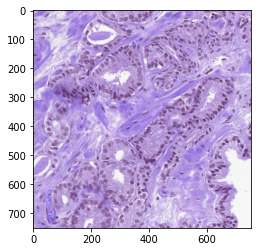

In [76]:
for image, _ in FV["train"]:
    break
plt.imshow(np.array(torch.permute(image, (1, 2, 0))))

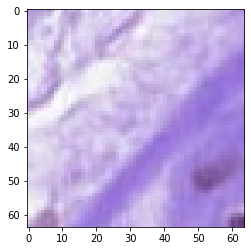

In [84]:
for image, _ in PV["train"]:
    break
plt.imshow(np.array(torch.permute(image, (1, 2, 0))))

## Model Arch

### Shared

In [85]:
class EncoderHead(nn.Module):
    def __init__(self, in_channels=3, num_hiddens=[16, 32], num_residual_layers=2, num_residual_hiddens=128, out_channels=None):
        super(EncoderHead, self).__init__()

        out_channels = num_hiddens[-1] if out_channels is None else out_channels

        self.layers = []
        c = in_channels
        for n_h in num_hiddens:
            self.layers.append(
                nn.Conv2d(
                    in_channels=c,
                    out_channels=n_h,
                    kernel_size=4,
                    stride=2,
                    padding=1,
                )
            )
            c = n_h
        self.layers = nn.ModuleList(self.layers)

        self._encoder = nn.Sequential(
            ResidualStack(
                in_channels=num_hiddens[-1],
                num_hiddens=num_hiddens[-1],
                num_residual_layers=num_residual_layers,
                num_residual_hiddens=num_residual_hiddens
            ),
            nn.Conv2d(
                in_channels=num_hiddens[-1],
                out_channels=out_channels,
                kernel_size=1,
                stride=1
            )
        )

    def forward(self, x):
        for idx, layer in enumerate(self.layers):
            if idx < len(self.layers) - 1:
                x = F.relu(layer(x))
            else:
                x = layer(x)
        return self._encoder(x)

In [86]:
class DecoderHead(nn.Module):
    def __init__(self, num_hiddens=[64, 32], out_channels=3, num_residual_layers=2, num_residual_hiddens=128):
        super(DecoderHead, self).__init__()

        self.layers = [
            ResidualStack(
                in_channels=num_hiddens[0],
                num_hiddens=num_hiddens[0],
                num_residual_layers=num_residual_layers,
                num_residual_hiddens=num_residual_hiddens
            )
        ]

        c = num_hiddens[0]
        for n_h in num_hiddens:
            self.layers.append(
                nn.ConvTranspose2d(
                    in_channels=c,
                    out_channels=n_h,
                    kernel_size=4,
                    stride=2,
                    padding=1,
                )
            )
            c = n_h

        self.layers.append(
                nn.Conv2d(
                    in_channels=c,
                    out_channels=out_channels,
                    kernel_size=3,
                    stride=1,
                    padding=1,
                )
        )

        self.layers = nn.ModuleList(self.layers)

    def forward(self, x):
        for idx, layer in enumerate(self.layers):
            if idx < len(self.layers) - 1:
                x = F.relu(layer(x))
            else:
                x = layer(x)
        return x

### (Soft) VQ-VAE

In [87]:
def sampling(z_mean, z_log_var):
    sampling_dim = z_mean.shape
    epsilon = torch.random.normal(mean=0.0, std=1.0, size=sampling_dim)
    return z_mean + torch.sqrt(torch.exp(z_log_var)) * epsilon


def information_dropout(z_mean, sigma=None, sigma0=1.0):
    batch = z_mean.shape[0]
    dim = z_mean.shape[1]
    e = torch.random.normal(mean=0.0, std=1.0, size=[batch, dim])
    log_normal = torch.exp(sigma * sigma0 * e)
    return torch.mul(z_mean, log_normal)


def soft_prob(dist, smooth):
    prob = torch.exp(-torch.mul(dist, 0.5 * smooth)) / torch.sqrt(smooth)
    probs = prob / torch.sum(prob, dim=1).unsqueeze(1)
    return probs


def add_noise(input_signal, noise_level):
    dims = input_signal.shape
    noise = torch.random.normal(std=noise_level, mean=0.0, size=dims)
    return input_signal + noise

In [88]:
class Residual(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        super(Residual, self).__init__()
        self._block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_channels=in_channels,
                      out_channels=num_residual_hiddens,
                      kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_channels=num_residual_hiddens,
                      out_channels=num_hiddens,
                      kernel_size=1, stride=1, bias=False)
        )
    
    def forward(self, x):
        return x + self._block(x)


class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(ResidualStack, self).__init__()
        self._num_residual_layers = num_residual_layers
        self._layers = nn.ModuleList([Residual(in_channels, num_hiddens, num_residual_hiddens)
                             for _ in range(self._num_residual_layers)])

    def forward(self, x):
        for i in range(self._num_residual_layers):
            x = self._layers[i](x)
        return F.relu(x)

In [89]:
class softVectorQuantizer(nn.Module):
    # b: batch size; q: number of channels; K: number of codewords; d:embedding_dim;
    def __init__(self, embedding_dim, num_embeddings, commitment_cost, name="vq_layer"):
        super(softVectorQuantizer, self).__init__()
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        self._commitment_cost = commitment_cost

        self._embedding = nn.Embedding(self._embedding_dim, self._num_embeddings)
        with torch.no_grad():
            self._embedding.weight.uniform_(-1, 1)

    def forward(self, inputs):
        mean, var = inputs
        input_shape = mean.shape

        assert (
            input_shape[-1] == self._embedding_dim
        ), "Mean is not same dim as embedding!"

        # Calculate distances
        distances = (
            torch.sum(mean**2, dim=1, keepdim=True)
            + torch.sum(self._embedding.weight**2, dim=0)
            - 2 * torch.matmul(mean, self._embedding.weight)
        )

        # soft operations
        smooth = 1.0 / torch.exp(var) ** 2

        probs = soft_prob(distances, smooth)  # expected shape: (b*q,K)
        probs = probs.unsqueeze(1)  # expected shape: (b*q,1,k)
        codebook = (
            self._embedding.weight.data.detach().clone()
        )  # expected shape: (1,d,k)
        codebook = codebook.unsqueeze(0)

        quantize_vector = torch.sum(codebook * probs, 2)  # expected shape (b*q,d)
        quantized = torch.reshape(quantize_vector, mean.shape)

        # VQ-VAE operations
        # shape: q*b
        # encoding_indices = tf.argmax(- distances, 1)
        # encodings = tf.one_hot(encoding_indices, self._num_embeddings)
        # reshape to: (b,h,w), where q=h*w
        # encoding_indices = tf.reshape(encoding_indices, tf.shape(inputs['z_mean'])[:-1])
        # shape: (b,h,w,latent_dims)
        # quantized = self.quantize(encoding_indices)

        e_latent_loss = F.mse_loss(quantized.detach(), mean)
        q_latent_loss = F.mse_loss(quantized, mean.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss

        quantized = mean + (quantized - mean).detach()
        avg_probs = torch.mean(probs, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        return loss, quantized.contiguous(), perplexity, probs

In [90]:
class VectorQuantizer1D(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer1D, self).__init__()

        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(
            -1 / self._num_embeddings, 1 / self._num_embeddings
        )
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        flat_input = inputs

        # Calculate distances
        distances = (
            torch.sum(flat_input**2, dim=1, keepdim=True)
            + torch.sum(self._embedding.weight**2, dim=1)
            - 2 * torch.matmul(flat_input, self._embedding.weight.t())
        )

        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(
            encoding_indices.shape[0], self._num_embeddings, device=inputs.device
        )
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight)

        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss

        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        # convert quantized from BHWC -> BCHW
        return (
            loss,
            quantized.contiguous(),
            perplexity,
            encoding_indices.view(inputs[0], -1),
            encodings.view(inputs[0], -1),
        )


class VectorQuantizerEMA2D(nn.Module):
    def __init__(
        self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5
    ):
        super(VectorQuantizerEMA2D, self).__init__()

        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()
        self._commitment_cost = commitment_cost
        
        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()
        
        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)
            
            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n)
            
            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)
            
            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        loss = self._commitment_cost * e_latent_loss
        
        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BHWC -> BCHW
        return (
            loss,
            quantized.permute(0, 3, 1, 2).contiguous(),
            perplexity,
            encoding_indices.view(input_shape[0], -1, input_shape[1], input_shape[2]),
            encodings.view(input_shape[0], -1, input_shape[1], input_shape[2]),
        )

## $\beta$-VAE

In [91]:
def reparametrize(mu, logvar):
    std = logvar.div(2).exp()
    eps = std.data.new(std.size()).normal_().clone().detach().requires_grad_(True)
    return mu + std * eps


class View(nn.Module):
    def __init__(self, size):
        super(View, self).__init__()
        self.size = size

    def forward(self, tensor):
        return tensor.view(self.size)


def kaiming_init(m):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        torch.nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0)
    elif isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d)):
        m.weight.data.fill_(1)
        if m.bias is not None:
            m.bias.data.fill_(0)


def normal_init(m, mean, std):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        m.weight.data.normal_(mean, std)
        if m.bias.data is not None:
            m.bias.data.zero_()
    elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
        m.weight.data.fill_(1)
        if m.bias.data is not None:
            m.bias.data.zero_()


def reconstruction_loss(x, x_recon, distribution):
    batch_size = x.size(0)
    assert batch_size != 0

    if distribution == 'bernoulli':
        recon_loss = F.binary_cross_entropy_with_logits(x_recon, x, size_average=False).div(batch_size)
    elif distribution == 'gaussian':
        recon_loss = F.mse_loss(x_recon, x, size_average=False).div(batch_size)
    else:
        recon_loss = None
    return recon_loss


def kl_divergence(mu, logvar):
    batch_size = mu.size(0)
    assert batch_size != 0
    if mu.data.ndimension() == 4:
        mu = mu.view(mu.size(0), mu.size(1))
    if logvar.data.ndimension() == 4:
        logvar = logvar.view(logvar.size(0), logvar.size(1))

    klds = -0.5*(1 + logvar - mu.pow(2) - logvar.exp())
    total_kld = klds.sum(1).mean(0, True)
    dimension_wise_kld = klds.mean(0)
    mean_kld = klds.mean(1).mean(0, True)

    return total_kld, dimension_wise_kld, mean_kld

In [92]:
class BetaVAE_H(nn.Module):
    """Model proposed in original beta-VAE paper(Higgins et al, ICLR, 2017)."""

    def __init__(self, num_hiddens=[32], z_dim=10, nc=3, args=None):
        super(BetaVAE_H, self).__init__()
        self.z_dim = z_dim
        self.nc = nc

        self._encoder = EncoderHead(
            in_channels=3,
            num_hiddens=num_hiddens,
            num_residual_layers=2,
            num_residual_hiddens=128
        )

        feat_x = num_hiddens[-1]*(2**len(num_hiddens))**2
        feat_x = 32*8*8

        self._linear = nn.Sequential(
            View((-1, feat_x)),
            nn.Linear(feat_x, z_dim * 2),
        )

        self._decoder = nn.Sequential(
            nn.Linear(z_dim, feat_x),
            # View((-1, num_hiddens[-1], 2**len(num_hiddens), 2**len(num_hiddens))),
            View((-1, num_hiddens[-1], 8, 8)),
            DecoderHead(
                num_hiddens=num_hiddens[::-1],
                out_channels=nc,
                num_residual_layers=2,
                num_residual_hiddens=128
            )
        )

        # self.weight_init()

        self.stn_enc = None
        if args is not None:
            self.stn_enc = STNClsNet(args)

        self.stn_dec = None
        if args is not None:
            self.stn_dec = STNClsNet(args)


    def weight_init(self):
        for block in self._modules:
            for m in self._modules[block]:
                kaiming_init(m)

    def forward(self, x):
        ret = {}
        if self.stn_enc is not None:
            x_stn = self.stn_enc(x)
            ret['x_stn_enc'] = x_stn
            x = x_stn
        x = self._encoder(x)
        distributions = self._linear(x)
        mu = distributions[:, : self.z_dim]
        logvar = distributions[:, self.z_dim :]
        z = reparametrize(mu, logvar)
        x_recon = F.sigmoid(self._decoder(z))
        if self.stn_dec is not None:
            x_recon = self.stn_dec(x_recon)
        ret["x_recon"] = x_recon
        ret["mu"] = mu
        ret["logvar"] = logvar

        return ret

In [93]:
class BetaVAE_B(nn.Module):
    """Model proposed in understanding beta-VAE paper(Burgess et al, arxiv:1804.03599, 2018)."""

    def __init__(self, args=None, num_hiddens=256, z_dim=10, nc=3):
        super(BetaVAE_B, self).__init__()
        self.nc = nc
        self.z_dim = z_dim

        self._encoder = nn.Sequential(
            EncoderHead(
                in_channels=3, num_hiddens=[16, (num_hiddens // 8), (num_hiddens // 8)]
            ),
            nn.Conv2d(
                in_channels=(num_hiddens // 8),
                out_channels=(num_hiddens // 8),
                kernel_size=4,
                stride=2,
                padding=1,
            ),
            View((-1, (num_hiddens // 8) * 4 * 4)),
            nn.Linear((num_hiddens // 8) * 4 * 4, num_hiddens),
            nn.Linear(num_hiddens, num_hiddens),
            nn.Linear(num_hiddens, z_dim * 2),
        )

        self._decoder = nn.Sequential(
            nn.Linear(z_dim, num_hiddens),
            nn.Linear(num_hiddens, num_hiddens),
            nn.Linear(num_hiddens, (num_hiddens // 8) * 4 * 4),
            View((-1, (num_hiddens // 8), 4, 4)),
            nn.ConvTranspose2d(
                in_channels=(num_hiddens // 8),
                out_channels=(num_hiddens // 8),
                kernel_size=4,
                stride=2,
                padding=1,
            ),
            DecoderHead(num_hiddens=[(num_hiddens // 8), (num_hiddens // 8), 16], out_channels=3),
        )
        self.weight_init()

    def weight_init(self):
        for block in self._modules:
            for m in self._modules[block]:
                kaiming_init(m)

    def forward(self, x):
        distributions = self._encoder(x)
        mu = distributions[:, : self.z_dim]
        logvar = distributions[:, self.z_dim :]
        z = reparametrize(mu, logvar)
        x_recon = F.relu(self._decoder(z).view(x.size()))

        return {"x_recon": x_recon, "mu": mu, "logvar": logvar}

In [94]:
class BetaVAE_H_flat(nn.Module):
    """Model proposed in original beta-VAE paper(Higgins et al, ICLR, 2017)."""

    def __init__(
        self,
        num_hiddens=[16, 32, 32],
        fc_hidden=[256],
        z_dim=10,
        nc=3,
        num_residual_layers=2,
        num_residual_hiddens=256,
        args=None,
    ):
        super(BetaVAE_H_flat, self).__init__()
        self.z_dim = z_dim
        self.nc = nc

        self._encoder = nn.Sequential(
            EncoderHead(in_channels=nc, num_hiddens=num_hiddens),
            ResidualStack(
                in_channels=num_hiddens[-1],
                num_hiddens=num_hiddens[-1],
                num_residual_layers=num_residual_layers,
                num_residual_hiddens=num_residual_hiddens,
            ),
            EncoderHead(in_channels=num_hiddens[-1], num_hiddens=[num_hiddens[-1]]),
        )
        self._linear = nn.Sequential(
            View((-1, num_hiddens[-1] * 4 * 4)),
            nn.Linear(num_hiddens[-1] * 4 * 4, fc_hidden[0]),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(fc_hidden[0], z_dim * 2),
        )

        self._decoder = nn.Sequential(
            nn.Linear(z_dim, fc_hidden[0]),
            nn.ReLU(True),
            nn.Linear(fc_hidden[0], num_hiddens[-1] * 4 * 4),
            View((-1, num_hiddens[-1], 4, 4)),
            DecoderHead(num_hiddens=[num_hiddens[-1]], out_channels=num_hiddens[-1]),
            ResidualStack(
                in_channels=num_hiddens[-1],
                num_hiddens=num_hiddens[-1],
                num_residual_layers=num_residual_layers,
                num_residual_hiddens=num_residual_hiddens,
            ),
            DecoderHead(num_hiddens=num_hiddens[::-1], out_channels=10),
            nn.Conv2d(10, nc, 3, stride=1, padding=2)
        )

        self.weight_init()

        self.stn_enc = None
        if args is not None:
            self.stn_enc = STNClsNet(args)

        self.stn_dec = None
        if args is not None:
            self.stn_dec = STNClsNet(args)

    def weight_init(self):
        for block in self._modules:
            for m in self._modules[block]:
                kaiming_init(m)

    def forward(self, x):
        ret = {}

        if self.stn_enc is not None:
            x = self.stn_enc(x)
            ret["x_stn_enc"] = x

        x = self._encoder(x)
        distributions = self._linear(x)

        mu = distributions[:, : self.z_dim]
        logvar = distributions[:, self.z_dim :]
        z = reparametrize(mu, logvar)

        x_recon = F.relu(self._decoder(z))

        if self.stn_dec is not None:
            x_recon = self.stn_dec(x_recon)

        ret["x_recon"] = x_recon
        ret["mu"] = mu
        ret["logvar"] = logvar

        return ret

In [95]:
class BetaVAE_H_flatv2(nn.Module):
    """Model proposed in original beta-VAE paper(Higgins et al, ICLR, 2017)."""

    def __init__(
        self,
        num_hiddens=[16, 32, 32],
        fc_hidden=[256],
        z_dim=10,
        nc=3,
        num_residual_layers=2,
        num_residual_hiddens=256,
        args=None,
    ):
        super(BetaVAE_H_flatv2, self).__init__()
        self.z_dim = z_dim
        self.nc = nc

        self._encoder = nn.Sequential(
            EncoderHead(in_channels=nc, num_hiddens=num_hiddens),
            ResidualStack(
                in_channels=num_hiddens[-1],
                num_hiddens=num_hiddens[-1],
                num_residual_layers=num_residual_layers,
                num_residual_hiddens=num_residual_hiddens,
            ),
            EncoderHead(in_channels=num_hiddens[-1], num_hiddens=[num_hiddens[-1]]),
        )
        self._linear = nn.Sequential(
            View((-1, num_hiddens[-1] * 4 * 4)),
            nn.Linear(num_hiddens[-1] * 4 * 4, fc_hidden[0]),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(fc_hidden[0], z_dim * 2),
        )

        self._decoder = nn.Sequential(
            nn.Linear(z_dim, fc_hidden[0]),
            nn.ReLU(True),
            nn.Linear(fc_hidden[0], num_hiddens[-1] * 4 * 4),
            View((-1, num_hiddens[-1], 4, 4)),
            DecoderHead(num_hiddens=[num_hiddens[-1]], out_channels=num_hiddens[-1]),
            ResidualStack(
                in_channels=num_hiddens[-1],
                num_hiddens=num_hiddens[-1],
                num_residual_layers=num_residual_layers,
                num_residual_hiddens=num_residual_hiddens,
            ),
            DecoderHead(num_hiddens=num_hiddens[::-1], out_channels=10),
            nn.Conv2d(10, nc, 3, stride=1, padding=2)
        )

        self.weight_init()

        self.stn_enc = None
        if args is not None:
            self.stn_enc = STNClsNet(args)

        self.stn_dec = None
        if args is not None:
            self.stn_dec = STNClsNet(args)

    def weight_init(self):
        for block in self._modules:
            for m in self._modules[block]:
                kaiming_init(m)

    def forward(self, x):
        ret = {}

        if self.stn_enc is not None:
            x = self.stn_enc(x)
            ret["x_stn_enc"] = x

        x = self._encoder(x)
        distributions = self._linear(x)

        mu = distributions[:, : self.z_dim]
        logvar = distributions[:, self.z_dim :]
        z = reparametrize(mu, logvar)

        x_recon = F.relu(self._decoder(z))

        if self.stn_dec is not None:
            x_recon = self.stn_dec(x_recon)

        ret["x_recon"] = x_recon
        ret["mu"] = mu
        ret["logvar"] = logvar

        return ret

In [96]:
class BetaVAETrainer():
    def __init__(self, model, config, path, dataset, device, args=None):
        self.path = path
        self.device = device

        self.objective = config['objective']

        self.model = model(
            num_hiddens=config['num_hiddens'],
            # fc_hidden=config['fc_hidden'],
            z_dim=config['z_dim'],
            nc=config['nc'],
            # num_residual_layers=config['num_residual_layers'],
            # num_residual_hiddens=config['num_residual_hiddens'],
            args=args,
        ).to(self.device)

        self.C_max = config['C_max']
        self.C_stop_iter = config['C_stop_iter']
        self.beta = config['beta']
        self.gamma = config['gamma']
        self.beta1 = config['beta1']
        self.beta2 = config['beta2']

        self.datasets = dataset

        make_dirs(self.path)

    def train(self, steps=3000, lr=1e-4, batch_size=256, loss_norm=0.02, display_every=10, checkpoint_every=100):
        train_loader = DataLoader(
            self.datasets["train"], batch_size=batch_size, shuffle=True, pin_memory=True
        )

        optimizer = optim.Adam(self.model.parameters(), lr=lr, betas=(self.beta1, self.beta2))
        self.model.train()

        train_res_recon_error = []
        C_max = torch.tensor([self.C_max], dtype=torch.float64).to(self.device)

        for i in trange(steps):
            (data, _) = next(iter(train_loader))

            data = data.to(self.device, dtype=torch.float32)
            optimizer.zero_grad()

            res = self.model(data)
            data_recon, mu, logvar = (
                res["x_recon"],
                res["mu"],
                res["logvar"],
            )

            recon_loss = reconstruction_loss(data, data_recon, 'gaussian') / loss_norm
            total_kld, dim_wise_kld, mean_kld = kl_divergence(mu, logvar)

            if self.objective == 'H':
                beta_vae_loss = recon_loss + self.beta*total_kld
            elif self.objective == 'B':
                C = torch.clamp(C_max/self.C_stop_iter*i, 0, C_max.item())
                beta_vae_loss = recon_loss + self.gamma*(total_kld-C).abs()

            beta_vae_loss.backward()
            optimizer.step()

            train_res_recon_error.append(beta_vae_loss.item())

            if (i + 1) % display_every == 0:
                print("%d iterations" % (i + 1))
                print("recon_error: {:.3f} total_kl: {:.3f} mean_kl: {:.3f}".format(
                    np.mean(train_res_recon_error[-100:]),
                    self.beta*total_kld.item(),
                    mean_kld.item()
                    )
                )
                print()

            if (i + 1) % checkpoint_every == 0:
                torch.save(self.model.state_dict(), join(self.path, "chkpt_{}.pth".format(i+1)))

        train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 201, 7)

        f = plt.figure(figsize=(8, 8), dpi=200)
        plt.plot(train_res_recon_error_smooth)
        plt.set_title("Beta-VAE loss.")
        plt.set_xlabel("iteration")

        plt.tight_layout()
        plt.savefig(join(self.path, "loss_plot.png"), bbox_inches='tight')

    def save(self):
        torch.save(self.model.state_dict(), join(self.path, "chkpt_final.pth"))

    def load(self):
        files = glob.glob(join(self.path, '*.pth'))
        self.model.load_state_dict(torch.load(files[-1]))

## VQVAE

In [97]:
class VQVAE(nn.Module):
    def __init__(
        self,
        in_channels=3,
        num_hiddens=[64, 128, 256],
        num_residual_layers=2,
        num_residual_hiddens=256,
        num_embeddings=512,
        embedding_dim=64,
        commitment_cost=1,
        decay=0.9
    ):
        super(VQVAE, self).__init__()

        self.embedding_dim = embedding_dim

        self._encoder = EncoderHead(in_channels, num_hiddens, num_residual_layers=num_residual_layers,
            num_residual_hiddens=num_residual_hiddens, out_channels=embedding_dim
        )

        self._vq_vae = VectorQuantizerEMA2D(
            num_embeddings, embedding_dim, commitment_cost, decay
        )

        self._pre_decoder = nn.Conv2d(
            in_channels=embedding_dim,
            out_channels=num_hiddens[-1],
            kernel_size=3,
            stride=1,
            padding=1,
        )

        self._decoder = DecoderHead(num_hiddens[::-1], in_channels)

    def forward(self, x):
        x = self._encoder(x)
        loss, quantized, perplexity, encodings_idx, encodings = self._vq_vae(x)
        x_recon = self._pre_decoder(quantized)
        x_recon = self._decoder(x_recon)

        return {
            "x_recon": x_recon,
            "loss": loss,
            "perplexity": perplexity,
            "quantized": quantized,
            "encodings_idx": encodings_idx,
            "encodings": encodings
        }

In [98]:
class VQVAETrainer:
    def __init__(self, config, path, datasets, device):
        self.path = path
        self.device = device

        self.model = VQVAE(
            in_channels=config['in_channels'],
            num_hiddens=config['num_hiddens'],
            num_residual_layers=config['num_residual_layers'],
            num_residual_hiddens=config['num_residual_hiddens'],
            num_embeddings=config['num_embeddings'],
            embedding_dim=config['embedding_dim'],
            commitment_cost=config['commitment_cost'],
            decay=config['decay'],
        ).to(device)

        self.datasets = datasets

        make_dirs(self.path)

    def train(self, steps=3000, lr=1e-4, batch_size=256, loss_norm=0.02, display_every=10, checkpoint_every=100):
        train_loader = DataLoader(
            self.datasets["train"], batch_size=batch_size, shuffle=True, pin_memory=True
        )

        optimizer = optim.Adam(self.model.parameters(), lr=lr, amsgrad=False)
        self.model.train()

        train_res_recon_error = []
        train_res_perplexity = []

        for i in trange(steps):
            (data, _) = next(iter(train_loader))

            data = data.to(self.device, dtype=torch.float32)
            optimizer.zero_grad()

            res = self.model(data)
            vq_loss, data_recon, perplexity = (
                res["loss"],
                res["x_recon"],
                res["perplexity"],
            )
            recon_error = F.mse_loss(data_recon, data) / loss_norm
            loss = recon_error + vq_loss
            loss.backward()

            optimizer.step()

            train_res_recon_error.append(recon_error.item())
            train_res_perplexity.append(perplexity.item())

            if (i + 1) % display_every == 0:
                print("%d iterations" % (i + 1))
                print("recon_error: %.3f" % np.mean(train_res_recon_error[-100:]))
                print()

            if (i + 1) % checkpoint_every == 0:
                torch.save(self.model.state_dict(), join(self.path, "chkpt_{}.pth".format(i+1)))

        train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 201, 7)
        train_res_perplexity_smooth = savgol_filter(train_res_perplexity, 201, 7)

        f = plt.figure(figsize=(16, 8), dpi=200)
        ax = f.add_subplot(1, 2, 1)
        ax.plot(train_res_recon_error_smooth)
        ax.set_yscale("log")
        ax.set_title("Soft-VQ-VAE Smoothed NMSE.")
        ax.set_xlabel("iteration")

        ax = f.add_subplot(1, 2, 2)
        ax.plot(train_res_perplexity_smooth)
        ax.set_title("Soft-VQ-VAE Smoothed Average codebook usage (perplexity).")
        ax.set_xlabel("iteration")

        plt.tight_layout()
        plt.savefig(join(self.path, "loss_plot.png"), bbox_inches='tight')

    def save(self):
        torch.save(self.model.state_dict(), join(self.path, "chkpt_final.pth"))

    def load(self):
        files = glob.glob(join(self.path, '*.pth'))
        self.model.load_state_dict(torch.load(files[-1]))

## VQVAE1D

In [99]:
class VQVAE1D(nn.Module):
    def __init__(
        self,
        in_channels=3,
        num_hiddens=[64, 128, 256],
        num_residual_layers=2,
        num_residual_hiddens=256,
        num_embeddings=512,
        embedding_dim=64,
        commitment_cost=1
    ):
        super(VQVAE1D, self).__init__()

        self.embedding_dim = embedding_dim

        self._encoder = nn.Sequential(
            EncoderHead(in_channels, num_hiddens),
            nn.Conv2d(in_channels=num_hiddens[-1],
                        out_channels=num_hiddens[-1],
                        kernel_size=4,
                        stride=2,
                        padding=1
                        ),
            nn.LeakyReLU(inplace=True)
        )

        self._residual_stack = ResidualStack(
            in_channels=num_hiddens[-1],
            num_hiddens=num_hiddens[-1],
            num_residual_layers=num_residual_layers,
            num_residual_hiddens=num_residual_hiddens,
        )

        self._pre_vq_conv = nn.Sequential(
            nn.Conv2d(in_channels=num_hiddens[-1],
                        out_channels=embedding_dim,
                        kernel_size=1,
                        stride=1),
            nn.LeakyReLU(inplace=True),
            View((-1, 256*16*16)),
            nn.Linear(256*16*16, embedding_dim),
        )

        self._vq_vae = VectorQuantizer1D(
            num_embeddings, embedding_dim, commitment_cost
        )

        self._pre_decoder = nn.Conv2d(
            in_channels=embedding_dim,
            out_channels=num_hiddens[-1],
            kernel_size=3,
            stride=1,
            padding=1,
        )

        self._residual_stack = ResidualStack(
            in_channels=num_hiddens[-1],
            num_hiddens=num_hiddens[-1],
            num_residual_layers=num_residual_layers,
            num_residual_hiddens=num_residual_hiddens,
        )

        self._decoder = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=num_hiddens[-1],
                out_channels=num_hiddens[-1],
                kernel_size=4,
                stride=2,
                padding=1,
            ),
            nn.LeakyReLU(inplace=True),
            DecoderHead(num_hiddens[::-1], in_channels),
        )

    def forward(self, x):
        x = self._encoder(x)
        x = self._residual_stack(x)
        x = self._pre_vq_conv(x)
        loss, quantized, perplexity, encodings_idx, encodings = self._vq_vae(x)
        x_recon = self._pre_decoder(quantized)
        x_recon = self._residual_stack(x_recon)
        x_recon = self._decoder(quantized)

        return {
            "x_recon": x_recon,
            "loss": loss,
            "perplexity": perplexity,
            "quantized": quantized,
            "encodings_idx": encodings_idx,
            "encodings": encodings
        }

## Soft-VQVAE

In [100]:
class SoftVQVAE(nn.Module):
    def __init__(
        self,
        in_channels=3,
        num_hiddens=[64, 128, 256],
        num_embeddings=512,
        embedding_dim=64,
        commitment_cost=2.5,
        hidden_dims=None,
    ) -> None:
        super(SoftVQVAE, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings

        modules = [EncoderHead(in_channels, num_hiddens)]
        if hidden_dims is None:
            hidden_dims = [256, 512]

        # Build Encoder
        in_channels = 128
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(
                        in_channels,
                        out_channels=h_dim,
                        kernel_size=3,
                        stride=2,
                        padding=1,
                    ),
                    nn.LeakyReLU(),
                )
            )
            in_channels = h_dim

        self._encoder = nn.Sequential(*modules)

        self._pre_vq_conv = nn.Conv2d(
            in_channels=h_dim, out_channels=h_dim, kernel_size=1, stride=1
        )

        self._linear = nn.Linear(hidden_dims[-1] * 4, self.embedding_size)

        self._mean = nn.Sequential(
            nn.Linear(self.embedding_size, self.embedding_size),
        )

        self._log_var = nn.Sequential(
            nn.Linear(self.embedding_size, self.num_embeddings),
        )

        self._vq_vae = softVectorQuantizer(
            embedding_dim=embedding_dim,
            num_embeddings=num_embeddings,
            commitment_cost=commitment_cost,
        )

        # Build Decoder
        modules = [DecoderHead(128, 3)]

        self.decoder_input = nn.Linear(self.embedding_size, hidden_dims[-1] * 4)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.appendleft(
                nn.Sequential(
                    nn.ConvTranspose2d(
                        hidden_dims[i],
                        hidden_dims[i + 1],
                        kernel_size=3,
                        stride=2,
                        padding=1,
                        output_padding=1,
                    ),
                    # nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU(),
                )
            )

        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
            nn.Conv2d(hidden_dims[-1], out_channels=3, kernel_size=3, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = torch.flatten(x, start_dim=1)
        x = self._linear(x)
        mean = self._mean(x)
        var = self._log_var(x)

        loss, quantized, perplexity, probs = self._vq_vae([mean, var])

        x_recon = self.decoder_input(quantized)
        x_recon = x_recon.view(-1, 512, 2, 2)
        x_recon = self.decoder(x_recon)
        x_recon = self.final_layer(x_recon)

        return {
            "x_recon": x_recon,
            "loss": loss,
            "perplexity": perplexity,
            "quantized": quantized,
            "probs": probs,
        }

## Train

In [106]:
betavae_config = {
    'objective': 'H',
    'num_hiddens': [32, 32, 64],
    'fc_hidden': [1024],
    'num_residual_layers': 2,
    'num_residual_hiddens': 64,
    'z_dim': 32,
    'nc': 3,
    'C_max': 100,
    'C_stop_iter': 1e5,
    'beta': 1,
    'gamma': 1000,
    'beta1': 0.9,
    'beta2': 0.999
}

In [107]:
args = {
    'span_range_height': 0.9,
    'span_range_width': 0.9,
    'grid_height': 4,
    'grid_width': 4,
    'model': 'unbounded_stn', # bounded_stn
    'image_height': 32,
    'image_width': 32,
}

args = EasyDict(args)

In [108]:
betavae_t = BetaVAETrainer(BetaVAE_H, betavae_config, './output/betavae/', PV, device, None) # No need for STN, patch size is very small

In [109]:
torch.autograd.set_detect_anomaly(True)

In [115]:
betavae_t.train(steps=5000, loss_norm=10, batch_size=64, lr=0.001)

  0%|          | 0/5000 [00:00<?, ?it/s]

/workspace/rochan/envs/work/lib/python3.9/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/workspace/rochan/envs/work/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


10 iterations
recon_error: 53.851 total_kl: 0.180 mean_kl: 0.006

20 iterations
recon_error: 45.936 total_kl: 0.658 mean_kl: 0.021

30 iterations
recon_error: 42.200 total_kl: 1.318 mean_kl: 0.041

40 iterations
recon_error: 39.401 total_kl: 2.784 mean_kl: 0.087

50 iterations
recon_error: 37.780 total_kl: 1.636 mean_kl: 0.051

60 iterations
recon_error: 36.360 total_kl: 2.005 mean_kl: 0.063

70 iterations
recon_error: 35.474 total_kl: 2.013 mean_kl: 0.063

80 iterations
recon_error: 34.609 total_kl: 1.520 mean_kl: 0.047

90 iterations
recon_error: 34.039 total_kl: 2.165 mean_kl: 0.068

100 iterations
recon_error: 33.469 total_kl: 1.856 mean_kl: 0.058

110 iterations
recon_error: 30.719 total_kl: 1.961 mean_kl: 0.061

120 iterations
recon_error: 29.697 total_kl: 1.769 mean_kl: 0.055

130 iterations
recon_error: 28.964 total_kl: 2.421 mean_kl: 0.076

140 iterations
recon_error: 28.587 total_kl: 1.907 mean_kl: 0.060

150 iterations
recon_error: 28.064 total_kl: 2.275 mean_kl: 0.071

160 

KeyboardInterrupt: 

In [270]:
vqvae_config = {
    'in_channels': 3,
    'num_hiddens': [32, 64, 128],
    'num_residual_layers': 4,
    'num_residual_hiddens': 32,
    'num_embeddings': 512,
    'embedding_dim': 64,
    'commitment_cost': 0.25,
    'decay': 0.99,
}

In [271]:
VQVAE_T = VQVAETrainer(vqvae_config, './output/vqvae/', PV, device)

In [272]:
VQVAE_T.train()

  0%|          | 0/3000 [00:00<?, ?it/s]

10 iterations
recon_error: 3.902



KeyboardInterrupt: 

In [116]:
def show(img):
    plt.figure(figsize=(20, 20))
    npimg = img
    fig = plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation="nearest")
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

In [117]:
def sample(model, validation_loader, device):
    model.eval()

    (valid_originals, _) = next(iter(validation_loader))
    valid_originals_ = valid_originals.to(device, dtype=torch.float)

    with torch.no_grad():
        output = model(valid_originals_)
        valid_reconstructions = output['x_recon']#['x_stn_enc']

    return valid_originals.cpu(), valid_reconstructions.cpu()

In [118]:
PVL = DataLoader(PV['test'], 32, True)

valid_originals, valid_reconstructions = sample(betavae_t.model, PVL, device)

In [ ]:
show(make_grid(valid_originals))
show(make_grid(valid_reconstructions))

In [122]:
def embed_plot(model, validation_loader, device):
    model.eval()

    embeddings = np.zeros(shape=(0,32))
    labels = np.zeros(shape=(0))

    i = 0
    for x, y in tqdm(validation_loader):

        if i == 100:
            break
        x = x.to(device, dtype=torch.float32)

        res = model(x)

        out = reparametrize(res['mu'], res['logvar'])

        labels = np.concatenate((labels, y.numpy().ravel()))
        embeddings = np.concatenate([embeddings, out.detach().cpu().numpy()],axis=0)

        i += 1


    from matplotlib import cm
    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE
    from torch.utils.data import DataLoader
    from torchvision import transforms

    tsne = TSNE(2, perplexity=50)
    tsne_proj = tsne.fit_transform(embeddings)

    # Plot those points as a scatter plot and label them based on the pred labels
    cmap = cm.get_cmap('tab20')
    fig, ax = plt.subplots(figsize=(8,8))
    num_categories = 3

    cr = [0, 2, 4]

    for lab in range(num_categories):
        indices = labels == lab
        ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(cr[lab])).reshape(1,4), label = lab ,alpha=0.5)

    ax.legend(fontsize='large', markerscale=2)
    # plt.axis([-50, 50, -50, 50])
    plt.show()


100%|██████████| 32/32 [00:01<00:00, 17.74it/s]


IndexError: boolean index did not match indexed array along dimension 0; dimension is 2000 but corresponding boolean dimension is 1000

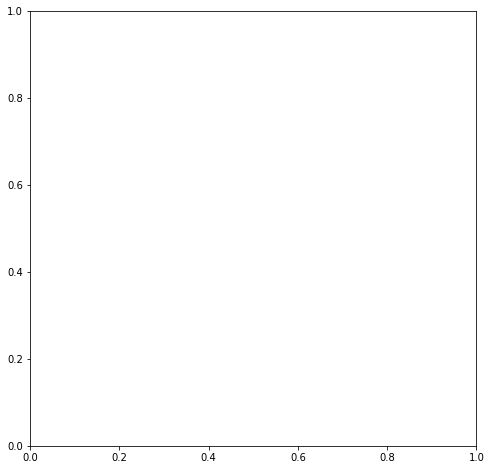

In [123]:
embed_plot(betavae_t.model, PVL, device)

In [ ]:
def create_ranges(start, stop, N, endpoint=True):
    if endpoint==1:
        divisor = N-1
    else:
        divisor = N
    steps = (1.0/divisor) * (stop - start)
    x = torch.arange(N).view(N, 1)
    return steps[:]*x + start[:]

In [247]:
def traverse(model, validation_loader, count, device):
    model.eval()

    with torch.no_grad():

        for x, y in tqdm(validation_loader):
            break

        x = x.to(device, dtype=torch.float32)
        res = model(x)
        out1 = reparametrize(res['mu'], res['logvar'])

        for x, y in tqdm(validation_loader):
            break

        x = x.to(device, dtype=torch.float32)
        res = model(x)
        out2 = reparametrize(res['mu'], res['logvar'])

        zs = create_ranges(out1[0, :].cpu(), out2[0, :].cpu(), count, True).to(device)

        return F.sigmoid(model._decoder(zs)).cpu()

In [248]:
variations = traverse(betavae_t.model, PVL, 32, device)

  0%|          | 0/442 [00:00<?, ?it/s]
/workspace/rochan/envs/work/lib/python3.9/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
  0%|          | 0/442 [00:00<?, ?it/s]


In [ ]:
show(make_grid(valid_originals))